# Aprendizado de Máquina em Séries Temporais
## Sea Surface Temperature Forecasting

- Gildo
- Maiser
- Victal
- Vítor Fróis: 12543440

# Imports

In [2]:
import numpy as np
import netCDF4 as nc
import xarray as xr
import numpy as np
import netCDF4 as nc
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import shiftgrid
import matplotlib.pyplot as plt
import pandas as pd
from dtw import *
from tqdm import tqdm

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [3]:
# fp = 'data/sst.mon.ltm.1991-2020.nc'
fp = 'data/sst.mnmean.nc'
ds = nc.Dataset(fp)
ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    climatology: Climatology is based on 1971-2000 SST, Xue, Y., T. M. Smith, and R. W. Reynolds, 2003: Interdecadal changes of 30-yr SST normals during 1871.2000. Journal of Climate, 16, 1601-1612.
    description: In situ data: ICOADS2.5 before 2007 and NCEP in situ data from 2008 to present. Ice data: HadISST ice before 2010 and NCEP ice after 2010.
    keywords_vocabulary: NASA Global Change Master Directory (GCMD) Science Keywords
    keywords: Earth Science > Oceans > Ocean Temperature > Sea Surface Temperature >
    instrument: Conventional thermometers
    source_comment: SSTs were observed by conventional thermometers in Buckets (insulated or un-insulated canvas and wooded buckets) or Engine Room Intaker
    geospatial_lon_min: -1.0
    geospatial_lon_max: 359.0
    geospatial_laty_max: 89.0
    geospatial_laty_min: -89.0
    geospatial_lat_max: 89.0
    geospatial_lat_min: -89.0
    

# Análise do Dataset
Vamos trabalhar com dados que possuem uma séries temporal para áreas do oceano com 2° de lado 

In [4]:
ds.variables.keys()

dict_keys(['lat', 'lon', 'time_bnds', 'time', 'sst'])

In [5]:
ds.variables['sst'].long_name

'Monthly Means of Sea Surface Temperature'

In [6]:
ds.variables['time_bnds'].long_name

'Time Boundaries'

In [7]:
ds.variables['time']

<class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    units: days since 1800-1-1 00:00:00
    long_name: Time
    delta_t: 0000-01-00 00:00:00
    avg_period: 0000-01-00 00:00:00
    prev_avg_period: 0000-00-07 00:00:00
    standard_name: time
    axis: T
    actual_range: [19723. 81722.]
unlimited dimensions: time
current shape = (2038,)
filling on, default _FillValue of 9.969209968386869e+36 used

In [8]:
ds['sst'][200,10,10]

masked

# Transformando em Dataframe

In [9]:
ds = xr.open_dataset(fp)
df = ds.to_dataframe()

In [173]:
df.head()

,lat,lon,time,nbnds,time_bnds,sst
0,88.0,0.0,1854-01-01,0,9.969210e+36,-1.8
2,88.0,0.0,1854-02-01,0,9.969210e+36,-1.8
4,88.0,0.0,1854-03-01,0,9.969210e+36,-1.8
6,88.0,0.0,1854-04-01,0,9.969210e+36,-1.8
8,88.0,0.0,1854-05-01,0,9.969210e+36,-1.8


In [174]:
df = df.reset_index()
df = df[df['nbnds'] == 0] # Garante que há apenas uma medição por área por tempo
df.head()

,index,lat,lon,time,nbnds,time_bnds,sst
0,0,88.0,0.0,1854-01-01,0,9.969210e+36,-1.8
1,2,88.0,0.0,1854-02-01,0,9.969210e+36,-1.8
2,4,88.0,0.0,1854-03-01,0,9.969210e+36,-1.8
3,6,88.0,0.0,1854-04-01,0,9.969210e+36,-1.8
4,8,88.0,0.0,1854-05-01,0,9.969210e+36,-1.8


In [12]:
df.shape

(32648760, 6)

In [13]:
ds.variables['sst']

<xarray.Variable (time: 2038, lat: 89, lon: 180)>
array([[[-1.8, -1.8, ..., -1.8, -1.8],
        [-1.8, -1.8, ..., -1.8, -1.8],
        ...,
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       [[-1.8, -1.8, ..., -1.8, -1.8],
        [-1.8, -1.8, ..., -1.8, -1.8],
        ...,
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       ...,

       [[-1.8, -1.8, ..., -1.8, -1.8],
        [-1.8, -1.8, ..., -1.8, -1.8],
        ...,
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       [[-1.8, -1.8, ..., -1.8, -1.8],
        [-1.8, -1.8, ..., -1.8, -1.8],
        ...,
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]]], dtype=float32)
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]

In [14]:
df['lat'].unique()

array([ 88.,  86.,  84.,  82.,  80.,  78.,  76.,  74.,  72.,  70.,  68.,
        66.,  64.,  62.,  60.,  58.,  56.,  54.,  52.,  50.,  48.,  46.,
        44.,  42.,  40.,  38.,  36.,  34.,  32.,  30.,  28.,  26.,  24.,
        22.,  20.,  18.,  16.,  14.,  12.,  10.,   8.,   6.,   4.,   2.,
         0.,  -2.,  -4.,  -6.,  -8., -10., -12., -14., -16., -18., -20.,
       -22., -24., -26., -28., -30., -32., -34., -36., -38., -40., -42.,
       -44., -46., -48., -50., -52., -54., -56., -58., -60., -62., -64.,
       -66., -68., -70., -72., -74., -76., -78., -80., -82., -84., -86.,
       -88.], dtype=float32)

In [15]:
df['lon'].unique()

array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
        22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
        44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,
        66.,  68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,
        88.,  90.,  92.,  94.,  96.,  98., 100., 102., 104., 106., 108.,
       110., 112., 114., 116., 118., 120., 122., 124., 126., 128., 130.,
       132., 134., 136., 138., 140., 142., 144., 146., 148., 150., 152.,
       154., 156., 158., 160., 162., 164., 166., 168., 170., 172., 174.,
       176., 178., 180., 182., 184., 186., 188., 190., 192., 194., 196.,
       198., 200., 202., 204., 206., 208., 210., 212., 214., 216., 218.,
       220., 222., 224., 226., 228., 230., 232., 234., 236., 238., 240.,
       242., 244., 246., 248., 250., 252., 254., 256., 258., 260., 262.,
       264., 266., 268., 270., 272., 274., 276., 278., 280., 282., 284.,
       286., 288., 290., 292., 294., 296., 298., 30

Portanto, os valores de latitude variam $\in [-88, 88]$ e longitude $\in [0, 360]$

# Visualização de SST

In [118]:
lats = ds.variables['lat'][:]
lons = ds.variables['lon'][:]
sst = ds.variables['sst'][:]
time = ds.variables['time'][:]
f = lambda x: ((x+180) % 360) - 180
lons = f(lons)

ind = np.argsort(lons)
lons = lons[ind]
sst = sst[:, :, ind]
# time = time[:, :, ind]

In [119]:
sst[0,:, :]

<xarray.Variable (lat: 89, lon: 180)>
array([[-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
       [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
       [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
       ...,
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]], dtype=float32)
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]

In [81]:
ds

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 2038, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2023-10-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
    sst        (time, lat, lon) float32 -1.8 -1.8 -1.8 -1.8 ... nan nan nan nan
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2023-11-03

In [82]:
print(sst.shape)

(2038, 89, 180)


In [83]:
def print_sst_map(ds, day):
    fig = plt.figure(num=None, figsize=(15, 15) ) 
    m = Basemap(projection='cyl', llcrnrlon=-180, llcrnrlat=-75, urcrnrlon=180, urcrnrlat=85, resolution='i')

    lon, lat = np.meshgrid(lons,lats)

    x, y = m(lon, lat)

    st = np.squeeze(sst[day,:,:])
    print(st.shape)
    print_date = numpy.datetime_as_string(time[day].values, unit='M')
    # cs = m.pcolor(x, y , st, cmap='jet')
    cs = m.contourf(x, y , st, cmap='jet', levels = 300)
    m.drawcoastlines()
    m.drawmapboundary()
    m.drawcountries(linewidth=1, linestyle='solid', color='k' ) 
    # m.drawmeridians(range(-80, -25, 5), color='k', linewidth=1.0, dashes=[4, 4], labels=[0, 0, 0, 1])
    # m.drawparallels(range(-50, 20, 5), color='k', linewidth=1.0, dashes=[4, 4], labels=[1, 0, 0, 0])
    plt.ylabel("Latitude", fontsize=15, labelpad=35)
    plt.xlabel("Longitude", fontsize=15, labelpad=20)
    cbar = m.colorbar(cs, location='right', pad="3%")
    cbar.set_label('SST (degC)', fontsize=13)
    plt.title(f'SST filled contour map for {print_date}', fontsize=15)
    plt.show()

(89, 180)


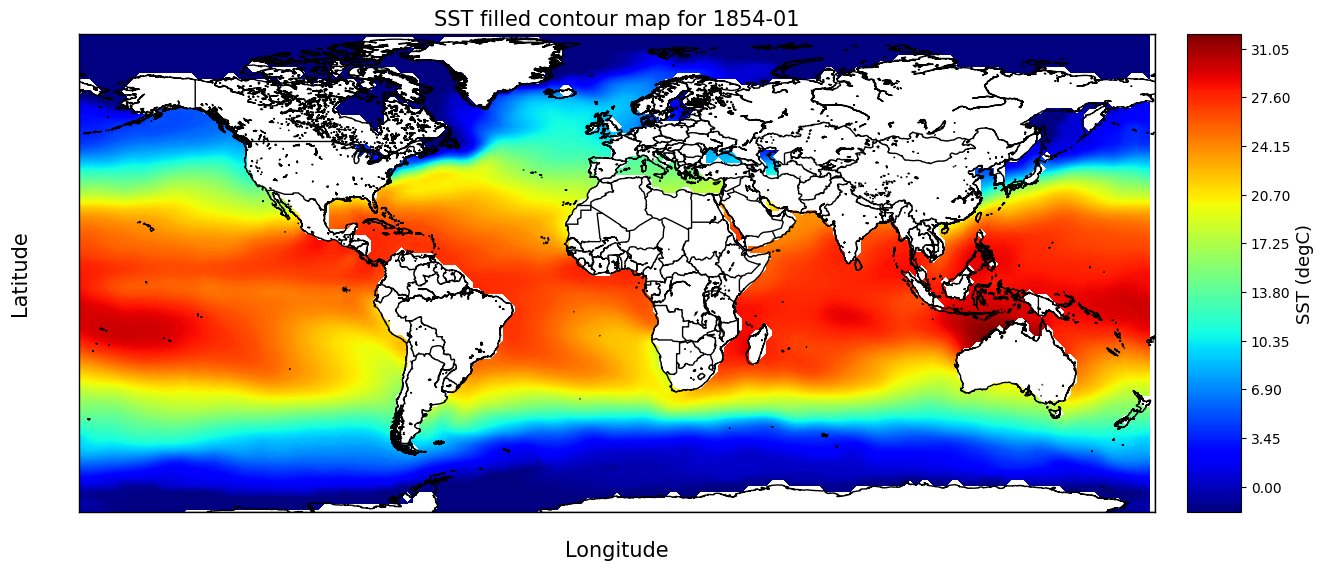

In [84]:
print_sst_map(ds, 0)

<xarray.Variable (lat: 89, lon: 180)>
array([[-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
       [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
       [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
       ...,
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]], dtype=float32)
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]


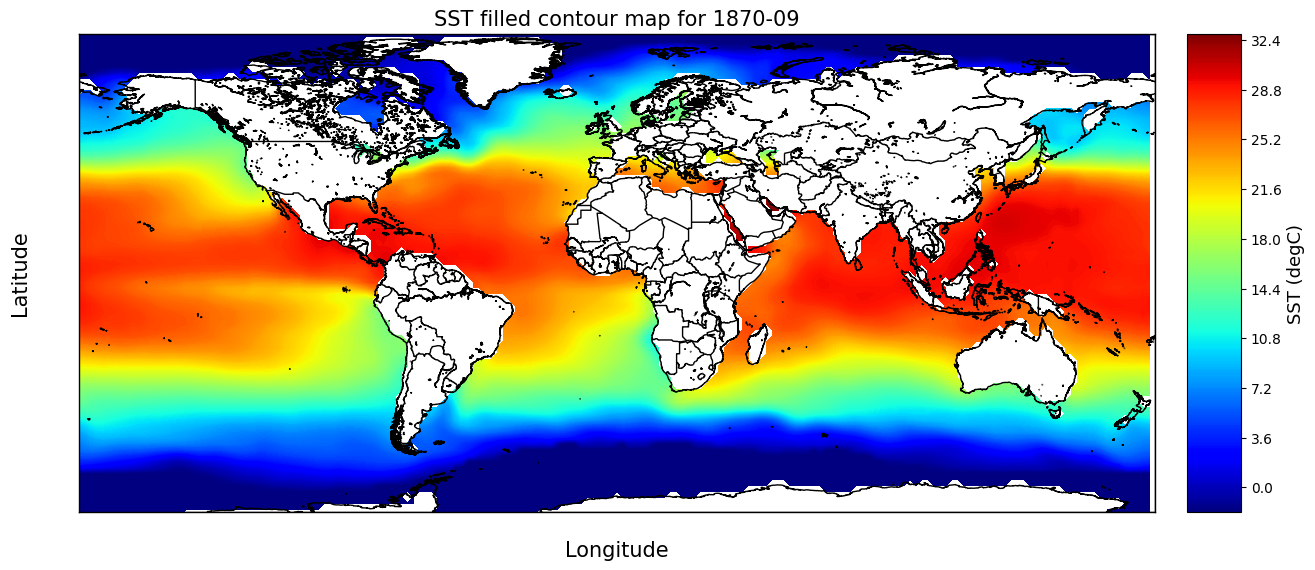

In [20]:
print_sst_map(ds, 200)

In [21]:
df.head()

,lat,lon,time,nbnds,time_bnds,sst
0,88.0,0.0,1854-01-01,0,9.969210e+36,-1.8
2,88.0,0.0,1854-02-01,0,9.969210e+36,-1.8
4,88.0,0.0,1854-03-01,0,9.969210e+36,-1.8
6,88.0,0.0,1854-04-01,0,9.969210e+36,-1.8
8,88.0,0.0,1854-05-01,0,9.969210e+36,-1.8


In [22]:
df['time']

0          1854-01-01
2          1854-02-01
4          1854-03-01
6          1854-04-01
8          1854-05-01
              ...    
65297510   2023-06-01
65297512   2023-07-01
65297514   2023-08-01
65297516   2023-09-01
65297518   2023-10-01
Name: time, Length: 32648760, dtype: datetime64[ns]

In [23]:
print(np.max(df['sst']))
print(np.min(df['sst']))

42.32636
-1.8


# Definição de Funções úteis

In [24]:
class SSTUtil:
    def get_sst_serie(df, lat: int, lon: int):
        return df[(df['lat'] == lat) & (df['lon'] == lon)].reset_index()
    def get_subserie(df: pd.DataFrame, start: int, window: float):
        return df[df['time'] > df['time'][start]][:window]
    def plot_sst(df: pd.DataFrame, start: int, window: float):
        fig, ax = plt.subplots()
        subserie = SSTUtil.get_subserie(df, start, window)
        ax.plot(subserie['time'], subserie['sst'], linewidth=2.0)
        plt.xticks(rotation=30)
        plt.show()

In [25]:
point_df = SSTUtil.get_sst_serie(df, 80, 40)
point_df

,index,lat,lon,time,nbnds,time_bnds,sst
0,3016240,80.0,40.0,1854-01-01,0,9.969210e+36,-1.800000
1,3016242,80.0,40.0,1854-02-01,0,9.969210e+36,-1.800000
2,3016244,80.0,40.0,1854-03-01,0,9.969210e+36,-1.800000
3,3016246,80.0,40.0,1854-04-01,0,9.969210e+36,-1.800000
4,3016248,80.0,40.0,1854-05-01,0,9.969210e+36,-1.800000
...,...,...,...,...,...,...,...
2033,3020306,80.0,40.0,2023-06-01,0,9.969210e+36,-0.377036
2034,3020308,80.0,40.0,2023-07-01,0,9.969210e+36,-0.337968
2035,3020310,80.0,40.0,2023-08-01,0,9.969210e+36,2.898502
2036,3020312,80.0,40.0,2023-09-01,0,9.969210e+36,2.445415


In [26]:
len(df)

32648760

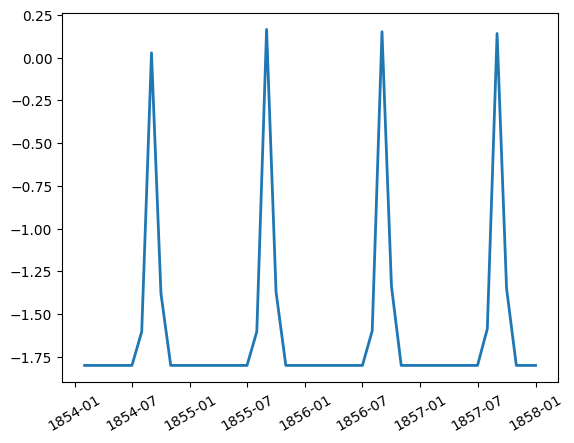

In [27]:
SSTUtil.plot_sst(point_df, 0, 48)

# SubserieDTW
A classe tem utilidades para pegar uma subsérie em um ponto e comparar com outras subséries no passado

In [28]:
class SubserieDTW:
    lat: int
    lon: int
    start: int
    window: float
    df: pd.DataFrame

    def __init__(self, df, lat, lon, start, window):
        print("Initializing")
        print(f"Lat: {lat}, Lon: {lon}")
        self.lat = lat
        self.lon = lon
        self.start = start
        self.window = window
        self.df = df

        point_df = SSTUtil.get_sst_serie(df, lat, lon)

        # Get main subserie
        self.main_subserie = SSTUtil.get_subserie(point_df, start, window)

        # Split into train/test
        self.train_df = point_df[:start]
        self.test_df = point_df[start:]
        self.df_len = len(point_df)
        print(f"Total length: {self.df_len}")
        print(f"Train/test proportion: {len(self.train_df)/self.df_len}/{len(self.test_df)/self.df_len}")

    
    def get_nearest_subseries(self):
        list_subseries = []
        np_main_subserie = np.array(self.main_subserie['sst'])
        for i in tqdm(range(0, len(self.train_df))):
            subserie_df = SSTUtil.get_subserie(self.train_df, i, self.window)
            np_subserie = np.array(subserie_df['sst'])
            try:
                if len(np_main_subserie) == len(np_subserie):
                    alignment = dtw(np_main_subserie, np_subserie, keep_internals=True)
                    subserie = {
                        'df': np_subserie,
                        'start': i,
                        'distance': alignment.distance,
                        'alignment': alignment
                    }

                    list_subseries.append(subserie)
            except ValueError as e:
                print(f"Got value error: {e}")
        list_subseries = sorted(list_subseries, key=lambda item: item['distance'], reverse=False)
        return list_subseries

In [29]:
s = SubserieDTW(df, 80, 40, 1800, 48)

Initializing
Lat: 80, Lon: 40
Total length: 2038
Train/test proportion: 0.8832188420019627/0.11678115799803729


### Obtendo as séries mais próximas

In [30]:
nearest = s.get_nearest_subseries()

100%|██████████| 1800/1800 [00:02<00:00, 647.35it/s]


fig, ax = plt.subplots()
ax.plot(point_df[''], y, linewidth=2.0)
plt.show()
plt.plot(point_df['sst'])

### Plotando Subséries mais próximas

12.885448038578033


<Axes: xlabel='Index', ylabel='Query value'>

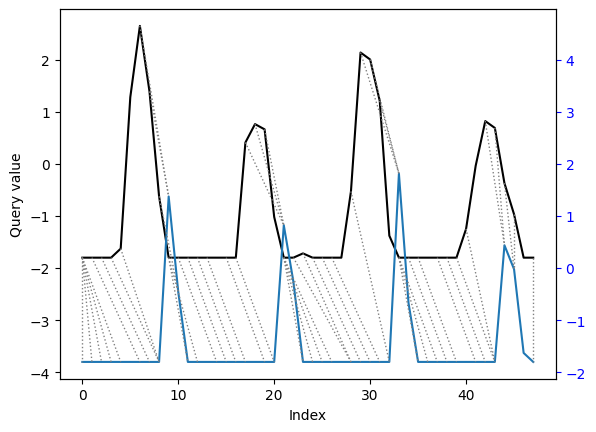

In [31]:
print(nearest[0]['distance'])
nearest[0]['alignment'].plot(type="twoway",offset=-2)

### Plotando Subséries mais distantes

43.65201711654663


<Axes: xlabel='Index', ylabel='Query value'>

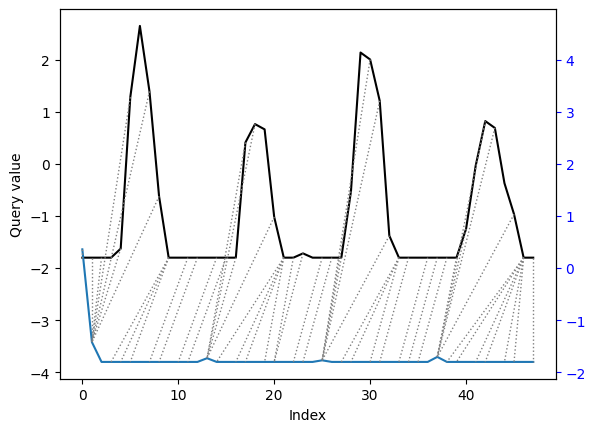

In [32]:
print(nearest[-1]['distance'])
nearest[-1]['alignment'].plot(type="twoway",offset=-2)

## Comparação com outras séries temporais

Essa parte tá meio estranha. Precisamos melhor pra fazer algo do tipo, mas penso que seria muito interessante pra visualização, pelo menos.

É bem pesado computacionalmente!

In [204]:
sst_similarity = sst[0,:,:]

In [205]:
sst_similarity[:, :] = 0

In [206]:
main_point_df = SSTUtil.get_subserie(
    SSTUtil.get_sst_serie(df, lat=80, lon=40),
    1000, 40
)
sst_similarity[80, 40] = -1
np_main_point = np.array(main_point_df['sst'])
main_point_max = np.max(np_main_point)
list_points = []
null_count = 0
total_count = 0
ocean_coord = [(20, 0), (80, 40), (80, 100)]
for latitude in tqdm(range(0, 40, 1)): #goes to 90
    for longitude in range(0, 40, 1): #goes to 180
        total_count += 1
        x = (latitude*2)
        y = (longitude*2)
        # print(x, y)
        full_point = SSTUtil.get_sst_serie(df, x, y)
        if len(full_point) == 0:
            null_count += 1
            continue
        # print(full_point)
        point_df = SSTUtil.get_subserie(
            full_point,
            1000, 40
        )
        np_point = np.array(point_df['sst'])
        # if np.isnan(np.sum(np_point)):
        #     null_count += 1
        #     continue
        distance = abs(np.max(np_point) - main_point_max)
        # alignment = dtw(np_main_point, np_point, keep_internals=True)
        # point = {
        #     'lat': latitude,
        #     'lon': longitude,
        #     'df': np_point,
        #     'distance': alignment.distance,
        #     'alignment': alignment
        # }
        # list_points.append(point)
        x = (latitude)
        y = (longitude)
        # print(x, y)
        sst_similarity[45-x, y+90] = distance

print(f"Null proportion: {100*(null_count/total_count)}")

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [01:44<00:00,  2.62s/it]

Null proportion: 0.0


<xarray.Variable (lat: 89, lon: 180)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]


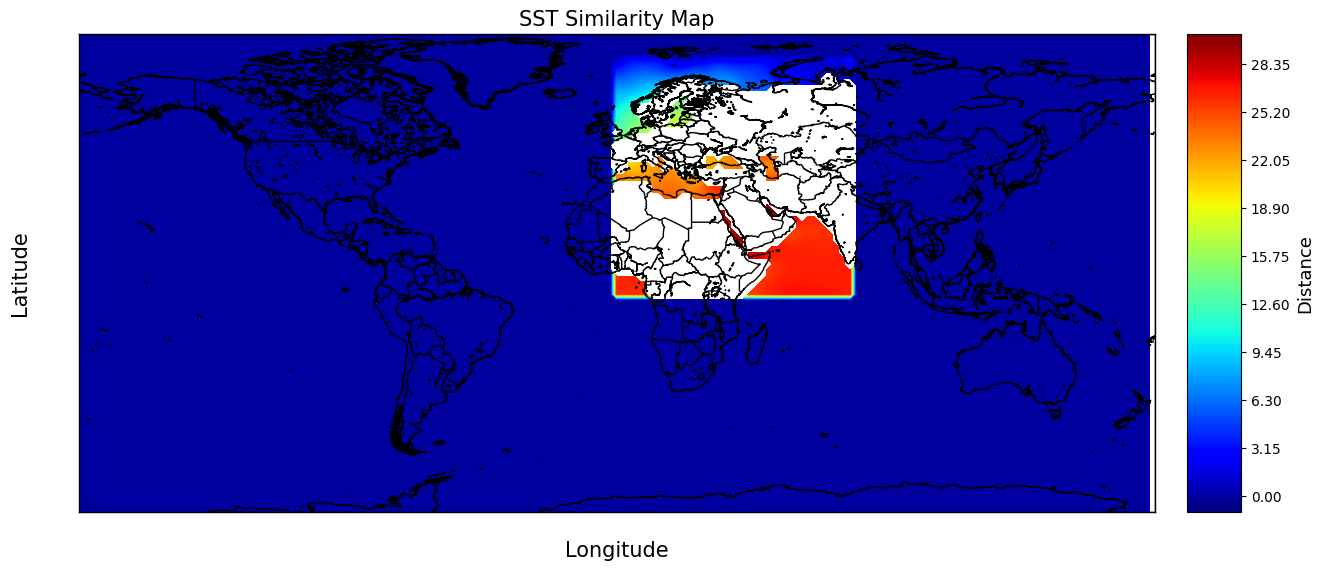

In [207]:
fig = plt.figure(num=None, figsize=(15, 15) ) 
m = Basemap(projection='cyl', llcrnrlon=-180, llcrnrlat=-75, urcrnrlon=180, urcrnrlat=85, resolution='i')

lon, lat = np.meshgrid(lons,lats)

x, y = m(lon, lat)

st = np.squeeze(sst_similarity)
print(sst_similarity)
# cs = m.pcolor(x, y , st, cmap='jet')
cs = m.contourf(x, y , sst_similarity, cmap='jet', levels = 300)
m.drawcoastlines()
m.drawmapboundary()
m.drawcountries(linewidth=1, linestyle='solid', color='k' ) 
# m.drawmeridians(range(-80, -25, 5), color='k', linewidth=1.0, dashes=[4, 4], labels=[0, 0, 0, 1])
# m.drawparallels(range(-50, 20, 5), color='k', linewidth=1.0, dashes=[4, 4], labels=[1, 0, 0, 0])
plt.ylabel("Latitude", fontsize=15, labelpad=35)
plt.xlabel("Longitude", fontsize=15, labelpad=20)
cbar = m.colorbar(cs, location='right', pad="3%")
cbar.set_label('Distance', fontsize=13)
plt.title(f'SST Similarity Map', fontsize=15)
plt.show()